In [13]:
%matplotlib widget

In [32]:
import numpy as np
import xtrack as xt
import xpart as xp
import xobjects as xo

import matplotlib.pyplot as plt
xo.context_cpu._suppress_warnings = True

In [33]:
collider = xt.Multiline.from_json('../../xtrack/test_data/hllhc15_collider/collider_00_from_mad.json')

Loading line from dict:   0%|          | 0/23684 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23688 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23684 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23688 [00:00<?, ?it/s]

Done loading line from dict.           


In [34]:
collider.vars['vrf400'] = 16

In [35]:
collider.install_beambeam_interactions(
    clockwise_line='lhcb1',
    anticlockwise_line='lhcb2',
    harmonic_number=35640,
    bunch_spacing_buckets=10, 
    sigmaz=0.1,
    ip_names=['ip1', 'ip5'],
    delay_at_ips_slots=[0, 0],
    num_long_range_encounters_per_side=[5, 5],
    num_slices_head_on=11)


In [36]:
collider.vars['on_x1'] = 200
collider.vars['on_x5'] = 200

In [37]:
tw1 = collider.lhcb1.twiss()
tw2 = collider.lhcb2.twiss(reverse=True)

Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.


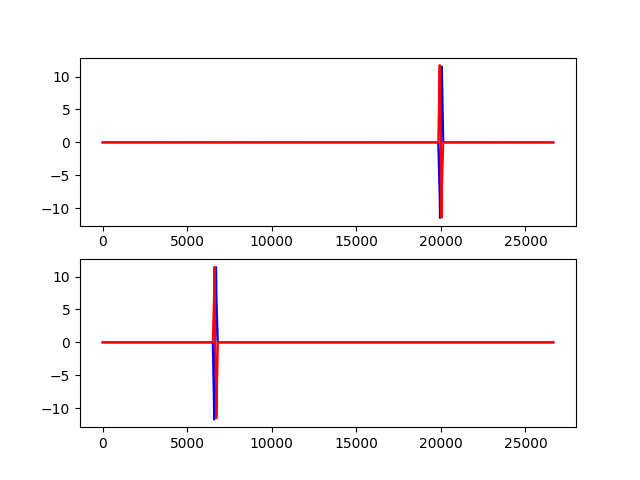

In [38]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(tw1.s, 1e3*tw1.x, color='b')
plt.plot(tw2.s, 1e3*tw2.x, color='r')
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(tw1.s, 1e3*tw1.y, color='b')
plt.plot(tw2.s, 1e3*tw2.y, color='r')

In [39]:
collider.configure_beambeam_interactions(
    num_particles=2.3e11, nemitt_x=2e-6, nemitt_y=2e-6)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [40]:
fp = collider.lhcb1.get_footprint(
    nemitt_x=2.5e-6, nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[
        xt.LinearRescale(knob_name='beambeam_scale', v0=0.0, dv=0.1)]
    )

Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.


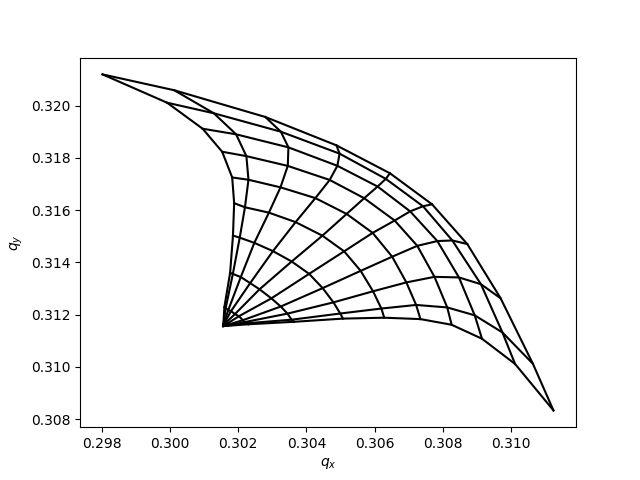

In [23]:
plt.figure()
fp.plot()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/200 [00:00<?, ?it/s]

Tracked in 6.909328791778535 seconds


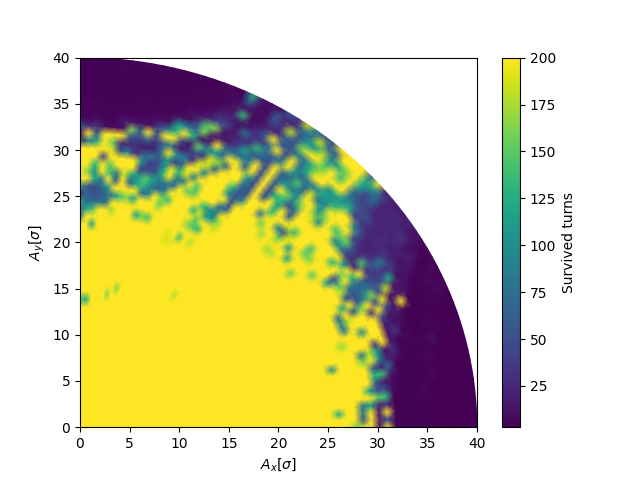

In [41]:
line = collider.lhcb1

for arc in ['12', '23', '34', '45', '56', '67', '78', '81']:
    line.vars[f'kod.a{arc}b1'] = 3.0
    line.vars[f'kof.a{arc}b1'] = 3.0

n_r = 50
n_theta = 60
x_normalized, y_normalized, r_xy, theta_xy = xp.generate_2D_polar_grid(
    r_range=(0, 40.), # beam sigmas
    theta_range=(0, np.pi/2),
    nr=n_r, ntheta=n_theta)

# Set initial momentum deviation
delta_init = 0 # In case off-momentum DA is needed

# Match particles to the machine optics and orbit
particles = line.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=3e-6, nemitt_y=3e-6, # normalized emittances
    delta=delta_init)

# # Optional: activate multi-core CPU parallelization
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

# Track
line.track(particles, num_turns=200, time=True, with_progress=5)

print(f'Tracked in {line.time_last_track} seconds')

# Sort particles to get the initial order
# (during tracking lost particles are moved to the end)
particles.sort(interleave_lost_particles=True)

plt.figure()
plt.pcolormesh(
    x_normalized.reshape(n_r, n_theta), y_normalized.reshape(n_r, n_theta),
    particles.at_turn.reshape(n_r, n_theta), shading='gouraud')
plt.xlabel(r'$A_x [\sigma]$')
plt.ylabel(r'$A_y [\sigma]$')
ax = plt.colorbar()
ax.set_label('Survived turns')

plt.show()